# WPM algorithm in X frame for big masks

Propagation algorithms for wave optics usually allows masks with a small size, since the propagation step is around the wavelength. When big masks, with long propagation distances is required, the involved matrices are huge and cannot be properly stored. 

For this case, we have developed WPM function in X frame, where only a small quantity of data are stored:

- Field at the end of the simulation.
- Field at the focus, that is, at position z with the maximum concentration of intensity.
- Field at an  axis.
- Field at a z axis.
- Global XZ field, with reduced sampling.
- XZ field, in a small region of interest.

For this case, we have implemented WPM in X and XY schemes. The refraction index in the XZ or XYZ space is not stored in a matrix, but a function is required.

In [10]:
from diffractio import np, plt, sp, um, mm, degrees
from diffractio.scalar_fields_XZ import Scalar_field_XZ
from diffractio.scalar_masks_XZ import Scalar_mask_XZ

from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_X import Scalar_source_X



In [11]:
from numpy import array, concatenate, diff, gradient, pi, sqrt, zeros
from numpy.lib.scimath import sqrt as csqrt
from scipy.fftpack import fft, fft2, fftshift, ifft, ifft2
from scipy.interpolate import RectBivariateSpline
import sys
import time

from diffractio.utils_math import get_k, ndgrid, nearest, nearest2
from diffractio.scalar_fields_X import WPM_schmidt_kernel
from diffractio.utils_optics import FWHM1D


In [12]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 250


# X scheme

## Parameters definition

In [13]:
x = np.linspace(-3 * mm, 3 * mm, 1024 * 8)
z = np.linspace(-1 * mm, 21 * mm, 1024 * 8)
wavelength = 10 * um


In [14]:
dx = x[1] - x[0]
dz = z[1] - z[0]

print("x = {:2.5f}, z = {:2.2f}".format(dx, dz))
print("x/wavelength = {:2.5f}, z/wavelength = {:2.2f}".format(
    dx / wavelength, dz / wavelength))


x = 0.73251, z = 2.69
x/wavelength = 0.07325, z/wavelength = 0.27


In [15]:
u0 = Scalar_source_X(x, wavelength)
u0.plane_wave(A=1, theta=0.0, z0=0.0)

In [16]:
def fn(x, z, wavelength):
    """refraction index definition for a given example.
 
    Args:
        x (np.array): x positions
        z (np.array): z positions
        wavelength (float): wavelength
    
    Returns:
        (np.array): XZ array with refraction index
    """
    
    u = Scalar_mask_XZ(x, z, wavelength)
    u.sphere(r0=(0, 6 * mm), radius=6 * mm, refraction_index=1.32, angle=0)
    return np.squeeze(u.n)

In [17]:
## This would be the standard code, defining huge matrices for refraction index and u field.

if False:
    u_3d = Scalar_mask_XZ(x, z, wavelength)
    u_3d.n = fn(x, z, wavelength)
    u_3d.draw_refraction_index(scale='scaled')
    u_3d.incident_field(u0)
    u_3d.WPM(has_edges=False, matrix=False, verbose=True)
    u_3d.draw(logarithm=True, draw_borders=True, scale='scaled')

In [18]:
# Region of interest (ROI)

xout_roi = np.linspace(-500 * um, 500 * um, 256)
zout_roi = np.linspace(15 * mm, 21 * mm, 256)
ROI = (xout_roi, zout_roi)

In [19]:
u_final_x, u_out_gv, u_out_roi, u_axis_x, u_axis_z, u_max, z_max = u0.WPM(
    fn,
    z,
    ROI=ROI,
    num_sampling=(1024, 1024),
    x_pos=0. * um,
    z_pos=12 * mm,
    get_u_max=True,
    has_edges=False,
    verbose=True)


AttributeError: 'Scalar_source_X' object has no attribute 'WPM'

## Output data

### Global region

In [42]:
print(u_out_gv)

Scalar_mask_XZ
 - x:  (1024,),   z:  (1024,),   u:  (1024, 1024)
 - xmin:       -3000.00 um,  xmax:      3000.00 um,  Dx:   5.87 um
 - zmin:       -1000.00 um,  zmax:      21000.00 um,  Dz:   21.51 um
 - Imin:       0.00,     Imax:      137.95
 - phase_min:  -180.00 deg, phase_max: 180.00 deg
 - wavelength: 10.00 um
 - date:       2022-11-06_21_27_22
 - info:       from WPM_no_storage_1D



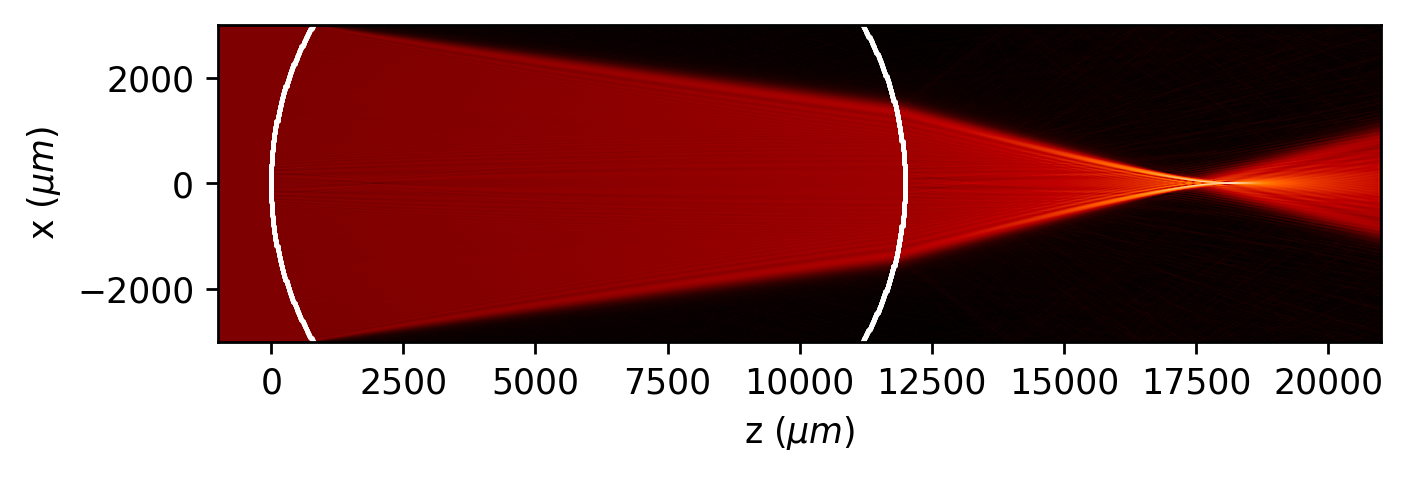

In [43]:
u_out_gv.draw(logarithm=1e1, draw_borders=True, scale='scaled')


## Region of interest

In [44]:
print(u_out_roi)

Scalar_mask_XZ
 - x:  (256,),   z:  (256,),   u:  (256, 256)
 - xmin:       -500.00 um,  xmax:      500.00 um,  Dx:   3.92 um
 - zmin:       15000.00 um,  zmax:      21000.00 um,  Dz:   23.53 um
 - Imin:       0.00,     Imax:      143.65
 - phase_min:  -179.99 deg, phase_max: 180.00 deg
 - wavelength: 10.00 um
 - date:       2022-11-06_21_27_22
 - info:       from WPM_no_storage_1D



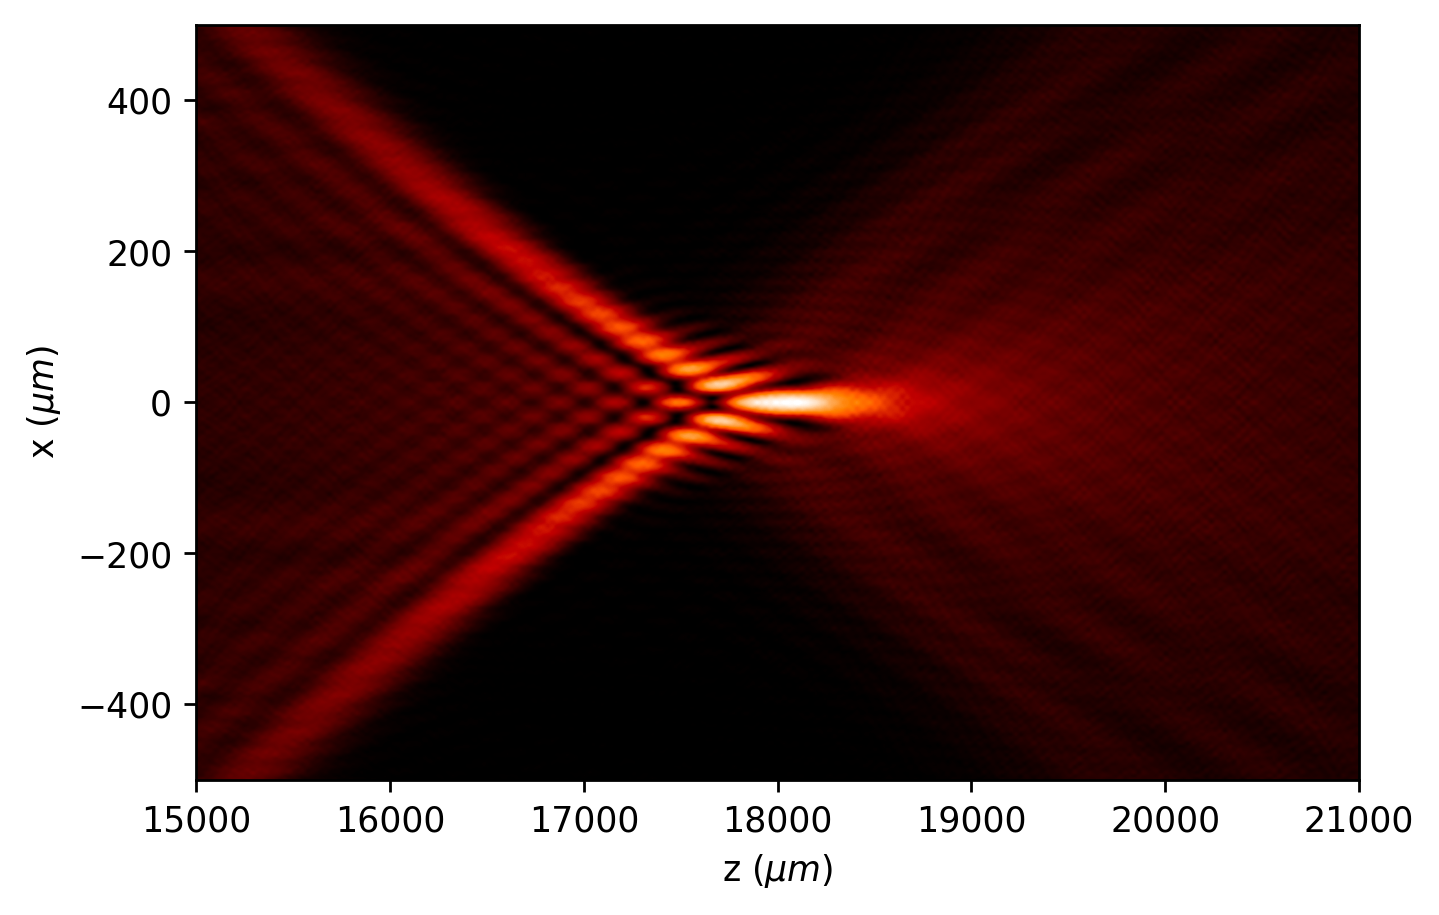

In [45]:
u_out_roi.draw(logarithm=1e-1)


## Field at focus

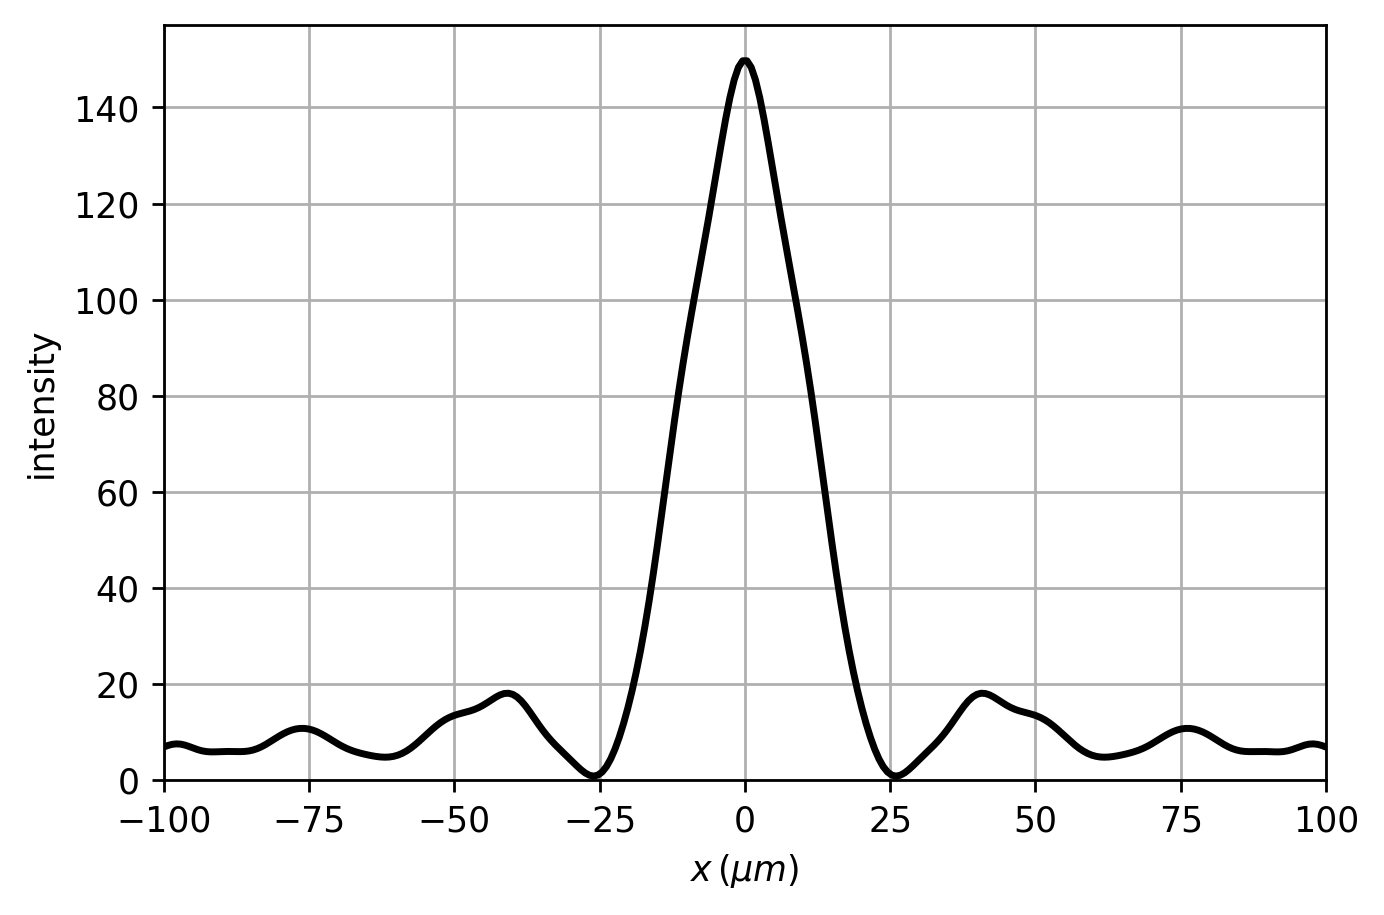

In [46]:
u_max.draw()
plt.xlim(-10 * wavelength, 10 * wavelength)
plt.ylim(ymin=0)
plt.grid('on')


## Field at a x given axis

In [47]:
print("pos focus = {:2.3f} mm".format(z_max / mm))


pos focus = 18.051 mm


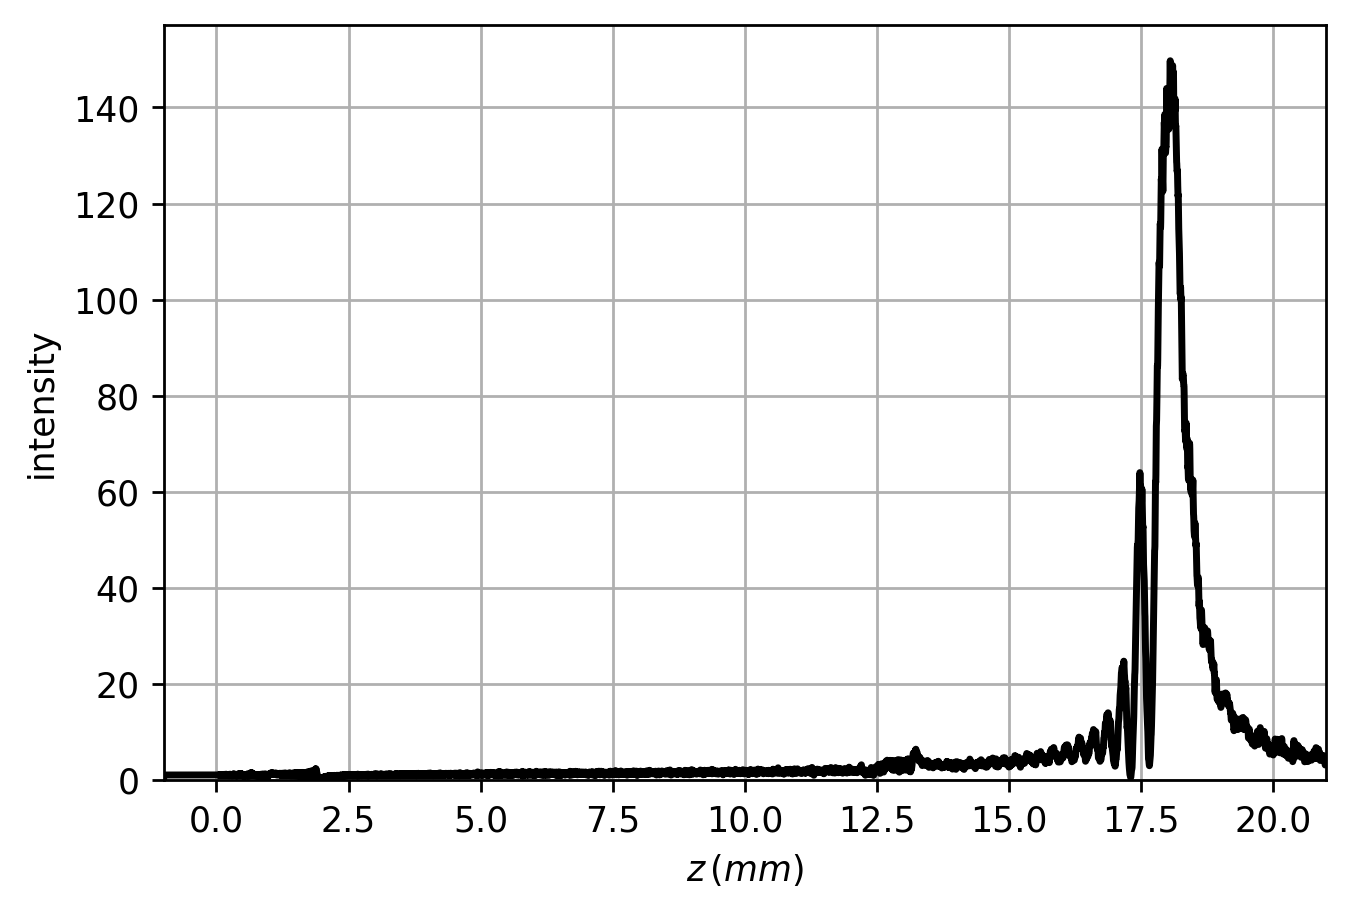

In [48]:
u_axis_x.draw(z_scale='mm')

plt.ylim(ymin=0)
plt.xlim(z[0] / mm, z[-1] / mm)
plt.grid('on')

## Final field

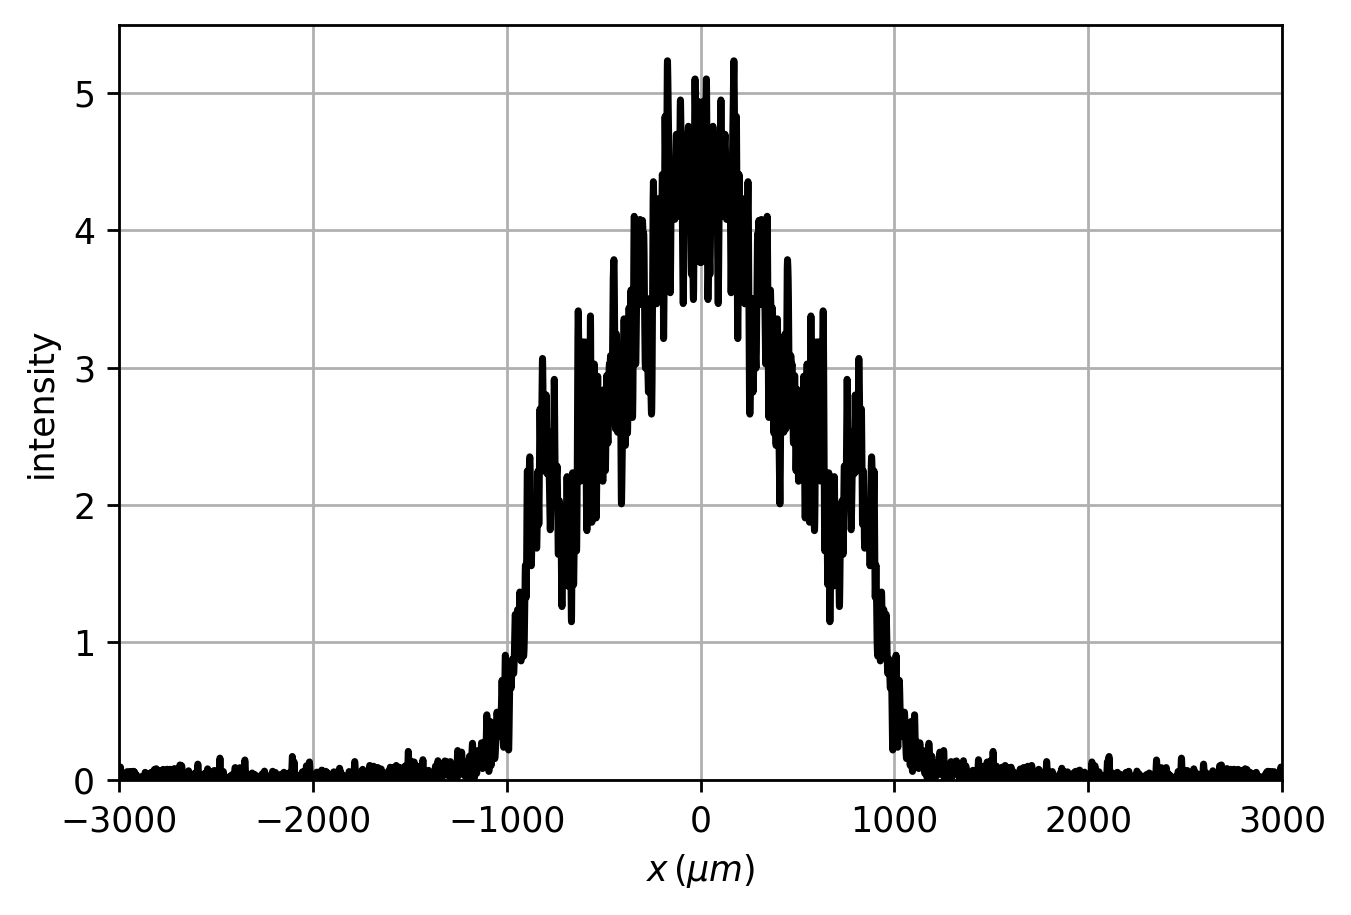

In [49]:
u_final_x.draw()
plt.ylim(ymin=0)
plt.grid('on')

## Field ina given z axis

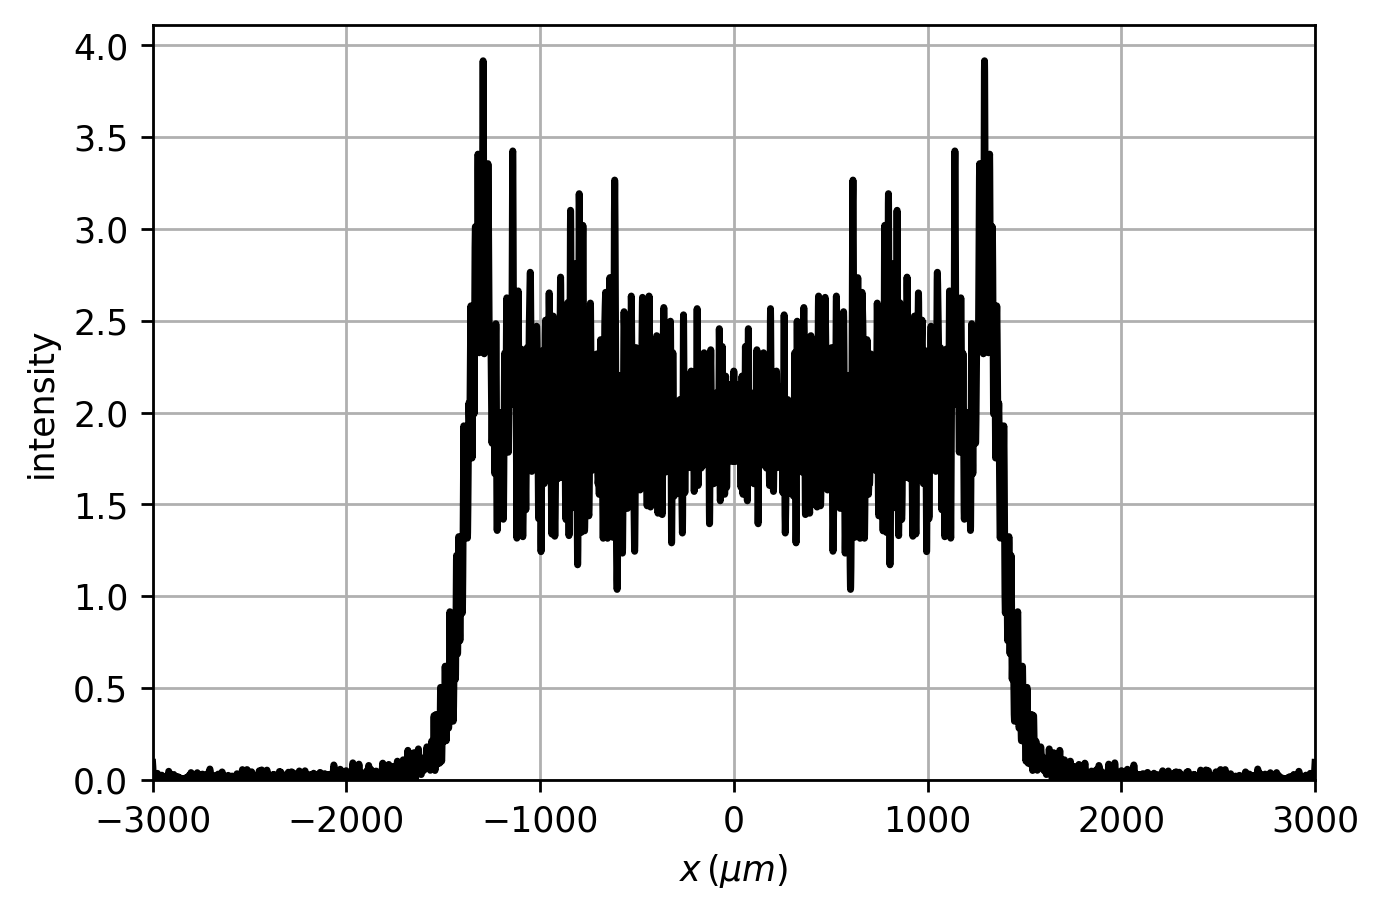

In [51]:
u_axis_z.draw()
plt.grid('on')
